In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
train_data["Gender"] = train_data["Gender"].apply(lambda x: 1 if x=="Male" else 0)

In [5]:
X = train_data.drop(["disease"],axis=1)
y = train_data["disease"]

In [6]:
#,stratify=y
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.3)

In [7]:
lr = LogisticRegression()

In [8]:
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
y_pred = lr.predict(x_test)
y_pred_prob = lr.predict_proba(x_test)[:,1]

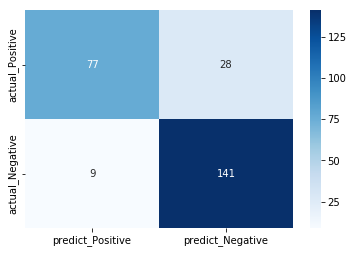

In [12]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
df_cm = pd.DataFrame(np.rot90(cm,2),index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
sns.heatmap(df_cm,annot=True,fmt="2g",cmap="Blues")
plt.yticks(va="center")
plt.show()

In [11]:
auc_score = roc_auc_score(y_true=y_test,y_score=y_pred_prob)
print(auc_score)

0.9280634920634921


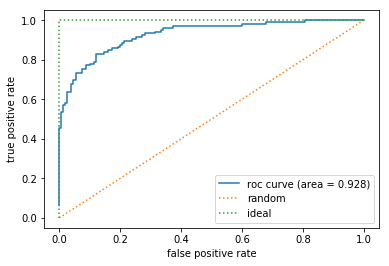

In [13]:
fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred_prob)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [25]:
test_data["Gender"] = test_data["Gender"].apply(lambda x: 1 if x=="Male" else 0)
test_pred_prob = lr.predict_proba(test_data)[:,1]
submit = pd.Series(data=test_pred_prob)
submit.to_csv("lr_prob.csv")

In [26]:
#交差2乗にして
X_target = X.drop(["Gender"],axis=1)
polynomial = PolynomialFeatures(degree=2,include_bias=False)
polynomial_arr = polynomial.fit_transform(X_target)
X_polynomial = pd.DataFrame(polynomial_arr,columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])
X_new = pd.concat([X,X_polynomial],axis=1)

In [27]:
fs_model = LogisticRegression(penalty="l1",random_state=0)
fs_threshold = "mean"
selector = SelectFromModel(fs_model,threshold=fs_threshold)

In [28]:
selector.fit(X_new,y)
mask = selector.get_support()
X_new_masked = X_new.loc[:,mask]

In [39]:
x_train,x_test,y_train,y_test = train_test_split(X_new_masked,y,stratify=y,random_state=0,test_size=0.3)
model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)[:,1]
auc_score = roc_auc_score(y_true=y_test,y_score=y_pred_prob)
print(auc_score)

In [ ]:
#ビニング
X_cut,bin_indice = pd.cut(X)